# Import

In [15]:
from _data_import_and_cleaning import *

In [16]:
palette

[(0.3280276816608997, 0.6805074971164936, 0.6802768166089965),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806)]

In [17]:
for x in [df_org, df_methods, df_payments]:
    display(x.head())

,customer_id,first_payment_date,channel
0,5568,2020-03-03,2
1,6763,2020-03-05,2
2,6816,2020-06-04,2
3,22350,2020-03-24,2
4,40800,2020-01-27,2


,payment_method_id,fixed_rate,variable_rate
0,3,0.29,0.000
1,11,0.25,0.018
2,17,0.39,0.000
3,19,0.25,0.000


,customer_id,payment_month,payment_method_id,total_transactions,total_volume
0,3120659,2020-01-01,3,241,2543.28
1,3627499,2020-01-01,3,430,27037.00
2,3611429,2020-01-01,3,117,6100.00
3,3772639,2020-01-01,3,27,720.56
4,3789659,2020-01-01,3,15,440.35


# Research

In [18]:
# Checking what is the most commonly-used payment method and what brings more revenue
total_transactions = df['total_transactions'].sum()
total_comission = df['total_comission'].sum()

(
    df
    .groupby('payment_method_id')
    .agg(
        sum_total_comission=('total_comission', 'sum'),
        sum_transactions=('total_transactions', 'sum')
    )
    .assign(
        share_of_transactions=lambda x: x.sum_transactions / total_transactions * 100,
        share_of_comission=lambda x: x.sum_total_comission / total_comission * 100
    )
    .sort_values('share_of_comission', ascending=False)
)

,sum_total_comission,sum_transactions,share_of_transactions,share_of_comission
payment_method_id,,,,
3.0,227183.97000,783393.0,77.884919,53.848263
11.0,131409.60914,56663.0,5.633435,31.147353
17.0,60891.48000,156132.0,15.522641,14.432798
19.0,2411.50000,9646.0,0.959005,0.571586


In [19]:
# Is this payment method unique or do those who use it also uses the others as well?
pm_11_customers = df[df['payment_method_id'] == 11]['customer_id'].unique()

(
    df
    [df.customer_id.isin(pm_11_customers)]
    .groupby('payment_method_id')
    .agg(
        sum_total_comission=('total_comission', 'sum'),
        sum_transactions=('total_transactions', 'sum')
    )
    .assign(
        share_of_transactions=lambda x: x.sum_transactions / x.sum_transactions.sum() * 100
    )
)

,sum_total_comission,sum_transactions,share_of_transactions
payment_method_id,,,
3.0,92269.30000,318170.0,74.742886
11.0,131409.60914,56663.0,13.310985
17.0,17428.71000,44689.0,10.498114
19.0,1541.00000,6164.0,1.448016


In [20]:
# Does it has bigger volume per order?
(
    df
    .groupby('payment_method_id')
    .agg(
        sum_total_comission=('total_comission', 'sum'),
        sum_total_volume=('total_volume', 'sum'),
        sum_total_transactions=('total_transactions', 'sum')
    )
    .assign(
        total_volume_per_transaction = lambda x: x.sum_total_volume / x.sum_total_transactions
    )
    .sort_values('total_volume_per_transaction', ascending=False)
)

,sum_total_comission,sum_total_volume,sum_total_transactions,total_volume_per_transaction
payment_method_id,,,,
19.0,2411.50000,1552116.44,9646.0,160.907779
11.0,131409.60914,6513547.73,56663.0,114.952398
17.0,60891.48000,14938554.02,156132.0,95.679003
3.0,227183.97000,67084333.45,783393.0,85.633052


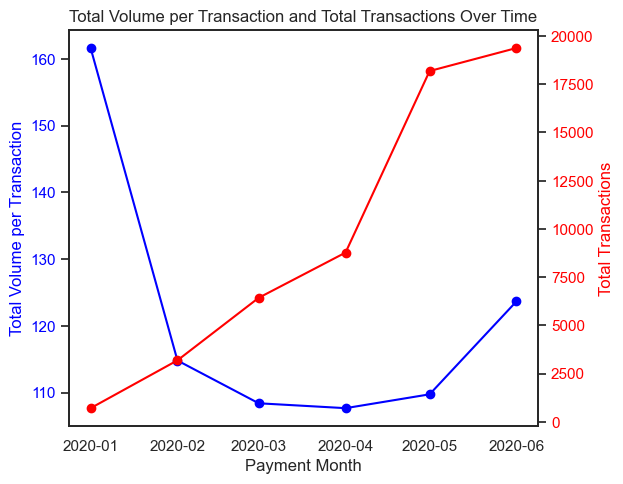

In [21]:
# Is it the same in the time periods?
_df = (
    df
    .groupby(['payment_month','payment_method_id'])
    .agg(
        sum_total_comission=('total_comission', 'sum'),
        sum_total_volume=('total_volume', 'sum'),
        sum_total_transactions=('total_transactions', 'sum')
    )
    .assign(
        total_volume_per_transaction = lambda x: x.sum_total_volume / x.sum_total_transactions
    )
    .sort_values('total_volume_per_transaction', ascending=False)
    .reset_index()
    .loc[lambda x: x.payment_method_id == 11]
    .sort_values('payment_month')
)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Payment Month')
ax1.set_ylabel('Total Volume per Transaction', color='b')
ax1.plot(_df['payment_month'], _df['total_volume_per_transaction'], 'bo-', label='Total Volume per Transaction')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a twin axis to plot total_transactions
ax2 = ax1.twinx()
ax2.set_ylabel('Total Transactions', color='r')
ax2.plot(_df['payment_month'], _df['sum_total_transactions'], 'ro-', label='Total Transactions')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Total Volume per Transaction and Total Transactions Over Time')
plt.show()

In [22]:
# The core source of comission income for all payment methods
_total_comission_income = df.total_comission.sum()

(
    pd.DataFrame(
        df
        [['fixed_rate_comission', 'variable_rate_comission']]
        .sum(),
        columns=['sum_comission']
    )
    .assign(
        share = lambda x: x.sum_comission / _total_comission_income * 100
    )
)

,sum_comission,share
fixed_rate_comission,304652.70000,72.210283
variable_rate_comission,117243.85914,27.789717


In [23]:
# The core source of comission income for this specific payment method
_total_comission_income = df[df.payment_method_id == 11].total_comission.sum()

(
    pd.DataFrame(
        df
        [df.payment_method_id == 11]
        [['fixed_rate_comission', 'variable_rate_comission']]
        .sum(),
        columns=['sum_comission']
    )
    .assign(
        share = lambda x: x.sum_comission / _total_comission_income * 100
    )
)

,sum_comission,share
fixed_rate_comission,14165.75000,10.779843
variable_rate_comission,117243.85914,89.220157


In [24]:
# How are the outliers in payment values distributed across different payment methods?
# Do larger sums indicate more compliance and the need to update tariffs?

_df = (
    df
    .assign(
        total_volume_per_transaction=lambda x: x.total_volume / x.total_transactions
    )
)

df_customer_volumes_per_transactions = (
    _df
    .groupby('customer_id')
    .agg(
        median_vpt = ('total_volume_per_transaction', 'median')
    )
)

Q1 = df_customer_volumes_per_transactions['median_vpt'].quantile(0.25)
Q3 = df_customer_volumes_per_transactions['median_vpt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_customer_volumes_per_transactions = (
    df_customer_volumes_per_transactions
    .assign(
        is_outlier = lambda x: 
            (x.median_vpt < lower_bound) 
            | (x.median_vpt > upper_bound),
        is_upper_outlier = lambda x: x.median_vpt > upper_bound
    )
)

display(
    df_customer_volumes_per_transactions[
        df_customer_volumes_per_transactions.is_upper_outlier
    ]
    .describe()
)



,median_vpt
count,1260.000000
mean,829.120262
std,1118.159876
min,260.000000
25%,335.922500
50%,484.000000
75%,875.432625
max,14520.000000


In [25]:
upper_bound

259.9777122257807

In [50]:
_df = df_customer_volumes_per_transactions.reset_index()

display(
    _df
    .merge(
        (
            df
            .groupby('customer_id')
            .agg(total_volume=('total_volume', 'sum'), total_comission=('total_comission', 'sum'))
            .reset_index()
        ),
        on='customer_id',
        how='left'
    )
    .groupby('is_upper_outlier')
    .agg(
        customers=('customer_id', 'nunique'),
        total_volume=('total_volume', 'sum'),
        total_comission=('total_comission', 'sum')
    )
    .assign(
        percentage_customers = lambda x: x.customers / x.customers.sum() * 100,
        percentage_volume = lambda x: x.total_volume / x.total_volume.sum() * 100,
        percentage_comission = lambda x: x.total_comission / x.total_comission.sum() * 100
    )
)

,customers,total_volume,total_comission,percentage_customers,percentage_volume,percentage_comission
is_upper_outlier,,,,,,
False,8838,63445299.14,359439.34786,87.522282,70.425485,85.196084
True,1260,26643252.50,62457.21128,12.477718,29.574515,14.803916


In [43]:
_df.columns

Index(['customer_id', 'median_vpt', 'is_outlier', 'is_upper_outlier'], dtype='object')

In [52]:
# How are they distributed across payment types?
_df = df_customer_volumes_per_transactions.reset_index()

total_cases_customers = _df[_df.is_upper_outlier].customer_id.nunique()

(
    df
    [df.customer_id.isin(_df[_df.is_upper_outlier].customer_id)]
    .groupby('payment_method_id')
    .agg(
        n_customers=('customer_id', 'nunique'),
        sum_total_comission=('total_comission', 'sum'),
        sum_total_transactions=('total_transactions', 'sum'),
        sum_total_volume=('total_volume', 'sum')
    )
    .assign(
        share_customers = lambda x: round(x.n_customers / total_cases_customers * 100, 2),
        share_comission = lambda x: round(x.sum_total_comission / x.sum_total_comission.sum() * 100, 2),
        share_transactions = lambda x: round(x.sum_total_transactions / x.sum_total_transactions.sum() * 100, 2),
        share_volume = lambda x: round(x.sum_total_volume / x.sum_total_volume.sum() * 100, 2)
    )
    .sort_values('share_volume', ascending=False)
    [['share_customers', 'share_comission', 'share_transactions', 'share_volume']]   
)

,share_customers,share_comission,share_transactions,share_volume
payment_method_id,,,,
3.0,87.62,18.90,84.09,84.10
11.0,17.14,79.37,9.64,10.09
17.0,13.41,1.43,4.73,3.97
19.0,6.51,0.30,1.53,1.83


In [26]:
df_customer_volumes_per_transactions

,median_vpt,is_outlier,is_upper_outlier
customer_id,,,
5568.0,53.075000,False,False
6763.0,12.100000,False,False
6816.0,302.500000,True,True
22350.0,15.000000,False,False
40800.0,30.503704,False,False
...,...,...,...
4496799.0,16.850000,False,False
4498219.0,1.005000,False,False
4498909.0,8.983333,False,False


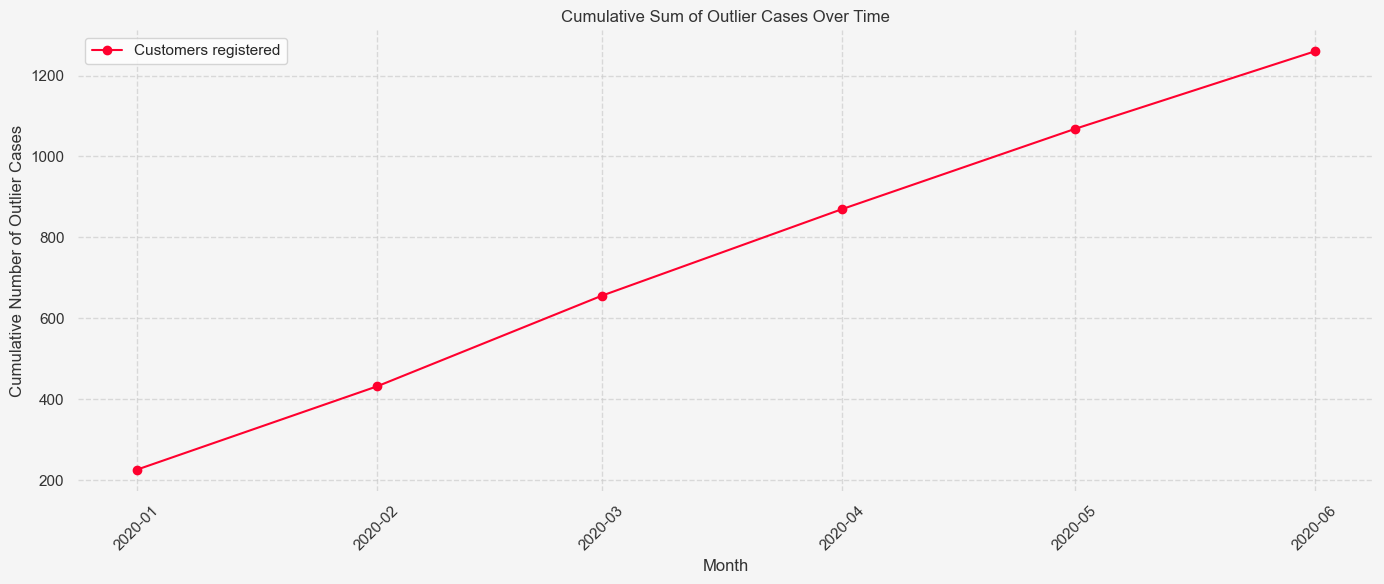

In [41]:
_df = (
    df_org[
        df_org.customer_id.isin(
            df_customer_volumes_per_transactions[
                df_customer_volumes_per_transactions.is_upper_outlier
            ]
            .reset_index()
            ['customer_id']
        )
    ]
    .assign(
        first_payment_month = lambda x: x.first_payment_date.dt.to_period('M').dt.to_timestamp()
    )
    .groupby('first_payment_month')
    .agg(
        n_customers=('customer_id', 'nunique')
    )
    .reset_index()
)

_df['cumsum_outlier_cases'] = _df['n_customers'].cumsum()

plt.figure(figsize=(14, 6), facecolor='#F5F5F5')
plt.gca().set_facecolor('#F5F5F5')

plt.plot(_df['first_payment_month'], _df['cumsum_outlier_cases'], marker='o', linestyle='-', color='#FF002E', label='Customers registered')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.title('Cumulative Sum of Outlier Cases Over Time', color='#333333')
plt.xlabel('Month', color='#333333')
plt.ylabel('Cumulative Number of Outlier Cases', color='#333333')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, color='#333333')
plt.yticks(color='#333333')
plt.tight_layout()

# Showing the plot
plt.legend()
plt.show()